Imports

In [3]:
import glob
import os
import time
import warnings



import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output
from keras.preprocessing.image import img_to_array, load_img
from keras.utils.generic_utils import get_custom_objects
from skimage.color import lab2rgb, rgb2lab
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Input, InputLayer, LeakyReLU,
                                     MaxPooling2D, UpSampling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence


##warnings.filterwarnings("ignore")

Data Loaders & Helpers

In [4]:
HEIGHT = 64
WIDTH  = 64

In [5]:
class DataGenerator(Sequence):
    def __init__(self, image_paths, batch_size):
        self.paths = image_paths
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        images = self.paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        
        return self.__getImages(images)

    def __getImages(self,paths):
        X_img=[]
        y_img=[]
        for imageDir in paths:
            try:
                image = img_to_array(load_img(imageDir,target_size=(HEIGHT,WIDTH)))
                lab_image = rgb2lab( (1/255) * image)
                X_img.append(lab_image[:,:,0].reshape(HEIGHT,WIDTH,1))
                y_img.append((lab_image[:,:,1:]/128).reshape(HEIGHT,WIDTH,2))
            except:
                continue
        X_img = np.array(X_img)
        y_img = np.array(y_img)
        return X_img,y_img
    def shuffle(self):
        np.random.shuffle(self.paths)

PARAMS

In [6]:
def custom_activation(x):
    return ((K.sigmoid(x)-0.5)/0.5)
get_custom_objects().update({'custom_activation':Activation(custom_activation)})




CODE

In [7]:
def make_generator_model():
    model = Sequential([
    Input(shape=(HEIGHT, WIDTH,1)),
    Conv2D(16,(3,3),padding='same',activation='relu',strides=1),
    LeakyReLU(),
    Conv2D(32,(3,3),padding='same',activation='relu',strides=1),
    Conv2D(32,(3,3),padding='same',activation='relu',strides=1),
    
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2),padding='same'),
    
    Conv2D(64,(3,3),padding='same',activation='relu',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2),padding='same'),
    
    Conv2D(128,(3,3),padding='same',activation='relu',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256,(3,3),padding='same',activation='relu',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    
    UpSampling2D((2, 2)),
    Conv2D(128,(3,3),padding='same',activation='relu',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    
    UpSampling2D((2, 2)),
    Conv2D(64,(3,3), padding='same',activation='relu',strides=1),
    LeakyReLU(),
    
    Conv2D(64,(3,3), padding='same',activation='relu',strides=1),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(32,(3,3),padding='same',activation='relu',strides=1),
    LeakyReLU(),
    
    Conv2D(2,(3,3), activation='tanh',padding='same',strides=1),
    ])
    return model
    

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        Input(shape=(HEIGHT, WIDTH,2)),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.1),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.MaxPool2D((2,2)),
        BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])


    return model

Custom 

In [9]:

def PSNR(y_true,y_pred):
	# print("CALLING PSNR")
	return tf.image.psnr(y_true,y_pred,2)



def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)(tf.ones_like(real_output) , real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def custom_binary(y_true,y_pred):
	# print("CALLING CUSTOM BINARY")
	return tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)(tf.convert_to_tensor(np.ones(y_pred.shape),dtype=tf.float32),y_pred)

def SSIM(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true +1 , y_pred+1, 2.0))




In [10]:
def create_gan():
    discriminator = make_discriminator_model()
    generator = make_generator_model()

    return generator,discriminator


Gan Created

In [11]:
generator, discriminator = create_gan()


generator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

In [12]:
imagepaths= os.listdir("../test2017")
imagepaths = list(map(lambda x:'../test2017/'+x,imagepaths))

In [13]:
test_input,reals = DataGenerator(imagepaths,4).__getitem__(0)
def generate_and_save_images(model,epoch):

  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(8, 8))
  fig.tight_layout()
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,(lmap,pred,real) in enumerate(list(zip(test_input,predictions,reals))):
        plt.subplot(4, 2, 2*(i+1))
        img = np.zeros((WIDTH,HEIGHT,3)).reshape(HEIGHT,WIDTH,3)
        
        img[:,:,0] =lmap.reshape(HEIGHT,WIDTH)
        
        
        img[:,:,1:] = pred.reshape(HEIGHT,WIDTH,2) *128
        # print("PREDICTION",img[:,:,1:].min(),img[:,:,1:].max())
        img = img 

        rgb_img = lab2rgb(img)
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.subplot(4,2,2*(i+1) -1)
      
        img[:,:,0] =lmap.reshape(HEIGHT,WIDTH) 
        img[:,:,1:] = real.reshape(HEIGHT,WIDTH,2)*128 
        img = img
        rgb_img = lab2rgb(img)

      


        plt.imshow(rgb_img)
        plt.axis('off')

 
  plt.savefig('./Results/image_at_epoch_{:06d}.png'.format(epoch))
  plt.close()

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
accGen = tf.keras.metrics.BinaryAccuracy()
accDisc = tf.keras.metrics.BinaryAccuracy()

In [16]:
@tf.function
def train_step( input_x , real_y ):


   
    accGen.reset_state()
    accDisc.reset_state()
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )

        real_y = real_y +tf.random.uniform(real_y.shape,maxval=0.01,minval=-0.01)
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        #ACC GEN

        

        #ACC DISC
        

        # PSNR
        # PSNR_loss = tf.reduce_mean(PSNR( real_y, generated_images ))

        # MAE_LOSS = tf.keras.losses.MeanAbsoluteError()(real_y, generated_images)

        SSIM_LOSS = tf.reduce_mean(SSIM(real_y, generated_images))  * -1

        disc_gen_loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)(tf.ones_like(generated_output), generated_output)
        
        # PSNR_loss + MAE_LOSS
        gen_loss =    SSIM_LOSS + disc_gen_loss

        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
    accGen.update_state(tf.ones_like(generated_output), generated_output)
    accDisc.update_state(tf.zeros_like(generated_output), generated_output)
    accDisc.update_state(tf.ones_like(generated_output), real_output)
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )
    
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    # PSNR_loss,MAE_LOSS
    return SSIM_LOSS,disc_gen_loss,gen_loss ,disc_loss, accGen.result(), accDisc.result()

In [17]:
def train(epochs=1000,batch_size=16,steps_epoch=50,save=100,offset=0,logfile='logs.txt'):
  data_gen = DataGenerator(imagepaths,batch_size)
  print(data_gen.__len__())
  for epoch in range(epochs):
    start = time.time()
    losses = np.asarray([0,0,0,0,0,0])
    

    for _ in range(data_gen.__len__()):
      images,labels = data_gen.__getitem__(0)
      data_gen.shuffle()
      loss_temp = train_step(images,labels)

      losses =np.add(losses,loss_temp)

  
    
    losses = losses / data_gen.__len__()

    # Save the model every 15 epochs
    if (epoch ) % save == 0:
      generate_and_save_images(generator,int(epoch+offset))
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch+offset, time.time()-start))
    print('Epoch {} , SSIM {} , GDL {}, TL {}, DL {}, DACC {}, DGACC{}'.format(epoch+offset,losses[0],losses[1],losses[2],losses[3],losses[4]*100,losses[5]*100))
    clear_output(wait=True)
    file_object = open(logfile, 'a')
    file_object.write('Epoch {} , SSIM {} , GDL {}, TL {}, DL {}, DACC {}, DGACC{} \n'.format(epoch+offset,losses[0],losses[1],losses[2],losses[3],losses[4]*100,losses[5]*100))
    file_object.close()

  # Generate after the final epoch






    

  generate_and_save_images(generator,
                           epochs)

In [18]:
# train(600,32,100,20)

In [19]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
# train(600,32,100,20,offset=1300)

In [21]:
def plot_image(imagep):
    image = img_to_array(load_img(imagep,target_size=(HEIGHT,WIDTH)))
    lab_image = rgb2lab( (1/255) * image)
    x = lab_image[:,:,0].reshape(1,HEIGHT,WIDTH,1)
   
    predictions = generator.predict(x)
    img = np.zeros((WIDTH,HEIGHT,3)).reshape(HEIGHT,WIDTH,3)
    # print(predictions.shape)
    img[:,:,0] =x.reshape(HEIGHT,WIDTH)
    img[:,:,1:] = predictions.reshape(HEIGHT,WIDTH,2) *128
    img = lab2rgb(img)
    plt.imshow(img)
    plt.axis('off')
    # plt.imshow(image/255)
    plt.axis('off')
    plt.show()

    
    


c:\Users\Marcos\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 23 pixels
  return func(*args, **kwargs)


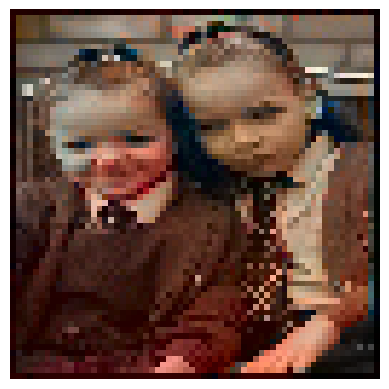

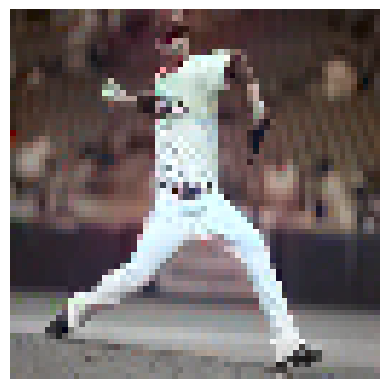

c:\Users\Marcos\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


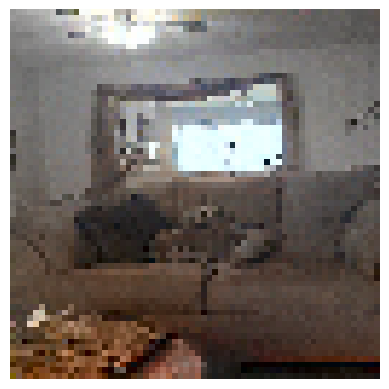

c:\Users\Marcos\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return func(*args, **kwargs)


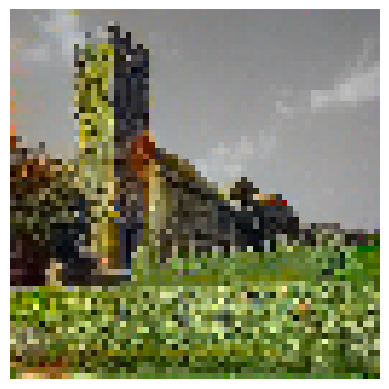

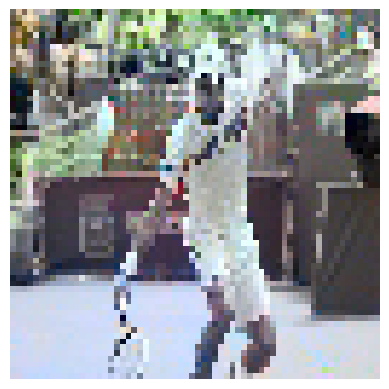

c:\Users\Marcos\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 61 pixels
  return func(*args, **kwargs)


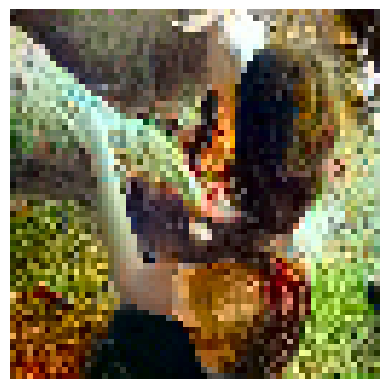

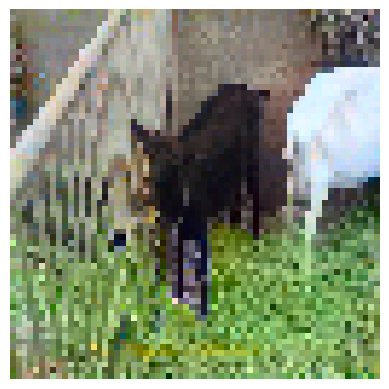

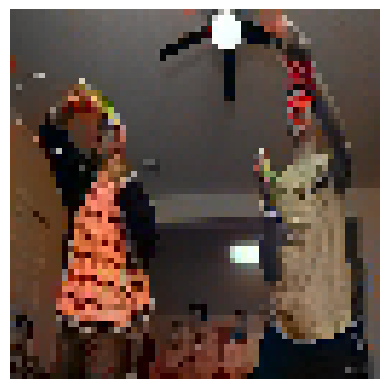

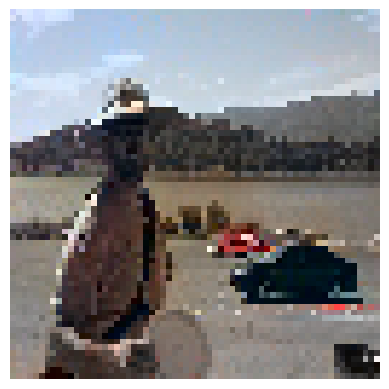

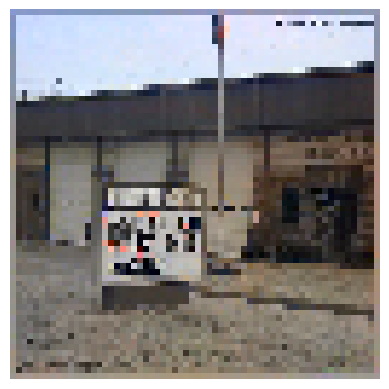

In [26]:
basePath =r"D:\GithubRepos\Deep_Learning-Image_Colorization\val2017"
testpaths= os.listdir(basePath)
testpaths = filter(lambda x: ".jpg" in x or ".png" in x,testpaths)
testpaths = list(map(lambda x:basePath+"\\"+x,testpaths))
np.random.shuffle(testpaths)

for i in testpaths[:10]:
    plot_image(i)

In [27]:
def eval_step() :

    test_gen = DataGenerator(testpaths,32)
    
    accGen.reset_state()
    accDisc.reset_state()
    losses = np.asarray([0,0,0,0,0,0])
    for i in range(test_gen.__len__()):
        input_x, real_y = test_gen.__getitem__(i)
   
   
        real_y = real_y +tf.random.uniform(real_y.shape,maxval=0.01,minval=-0.01)
        generated_images = generator( input_x , training=False)
            # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=False)
            # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=False)
            
    
        SSIM_LOSS = tf.reduce_mean(SSIM(real_y, generated_images))  * -1

        disc_gen_loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)(tf.ones_like(generated_output), generated_output)
            
            # PSNR_loss + MAE_LOSS
        gen_loss =    SSIM_LOSS + disc_gen_loss

            # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
        accGen.update_state(tf.ones_like(generated_output), generated_output)
        accDisc.update_state(tf.zeros_like(generated_output), generated_output)
        accDisc.update_state(tf.ones_like(generated_output), real_output)
        losses = np.add(losses,[SSIM_LOSS,disc_gen_loss,gen_loss ,disc_loss, accGen.result(), accDisc.result()])

    return losses / test_gen.__len__()

In [29]:
losses = eval_step()
print('SSIM {} , GDL {}, TL {}, DL {}, DACC {}, DGACC{}'.format(losses[0],losses[1],losses[2],losses[3],losses[4]*100,losses[5]*100))

SSIM -0.5944625720097001 , GDL 0.6879990298277253, TL 0.09353645781802523, DL 1.3850254412669285, DACC 64.64980256025959, DGACC50.05240804830174
